In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

from IPython.display import clear_output
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('ticks')

from os import listdir
from os.path import isfile, join
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download the data (public github)
!wget -N https://github.com/fiddler-labs/p2p-lending-data/raw/refs/heads/master/raw_data/accepted_2007_to_2018Q3.csv.gz

--2024-11-17 16:23:46--  https://github.com/fiddler-labs/p2p-lending-data/raw/refs/heads/master/raw_data/accepted_2007_to_2018Q3.csv.gz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/fiddler-labs/p2p-lending-data/refs/heads/master/raw_data/accepted_2007_to_2018Q3.csv.gz [following]
--2024-11-17 16:23:46--  https://media.githubusercontent.com/media/fiddler-labs/p2p-lending-data/refs/heads/master/raw_data/accepted_2007_to_2018Q3.csv.gz
Resolving media.githubusercontent.com (media.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 370087868 (353M) [application/octet-stream]
Saving to: ‘accepted_2007_to_2018Q3.csv

In [3]:
df = pd.read_csv('accepted_2007_to_2018Q3.csv.gz')

In [4]:

loan_df = pd.read_csv('accepted_2007_to_2018Q3.csv.gz')

print('Total Number of Rows:', '{:,}'.format(loan_df.shape[0]))
print('Total Number of Columns:', '{:,}'.format(loan_df.shape[1]))

Total Number of Rows: 2,132,287
Total Number of Columns: 151


In [5]:
import os
#os.getcwd()
os.chdir('/Users/Grant/Documents/Model Risk Mgmt/Project')

In [6]:
msk = loan_df['loan_status'].isin(['Fully Paid', 'Charged Off'])
loan_df = loan_df[msk]

#cast issue_d column to datetime for later use
loan_df['issue_d'] = pd.to_datetime(loan_df['issue_d'])
loan_df.to_pickle('loan_df0.pkl')

loan_df = pd.read_pickle('loan_df0.pkl').sample(frac=.05, random_state=0)

print('Total Number of Rows:', '{:,}'.format(loan_df.shape[0]))
print('Total Number of Columns:', '{:,}'.format(loan_df.shape[1]))

Total Number of Rows: 63,331
Total Number of Columns: 151


In [7]:
def get_missing_values_table(df):
    #Number of null values by column
    missing_values_df = pd.DataFrame(df.isnull().sum(),columns=['Missing_Count'])
    
    #Portion of null values by column
    missing_values_df['Portion_Missing'] = missing_values_df['Missing_Count']/df.shape[0]

    #Sort by Missing_Count
    missing_values_df = missing_values_df.sort_values(by='Missing_Count',ascending=False)  
    
    return missing_values_df

missing_values_df = get_missing_values_table(loan_df)
missing_values_df.head()

,Missing_Count,Portion_Missing
next_pymnt_d,63331,1.000000
member_id,63331,1.000000
orig_projected_additional_accrued_interest,63188,0.997742
sec_app_mths_since_last_major_derog,63101,0.996368
hardship_length,63100,0.996352


In [8]:
pd.set_option('display.max_columns', None)
print(df.columns.tolist())

['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq',

Number of Columns with under 15% missing values: 93


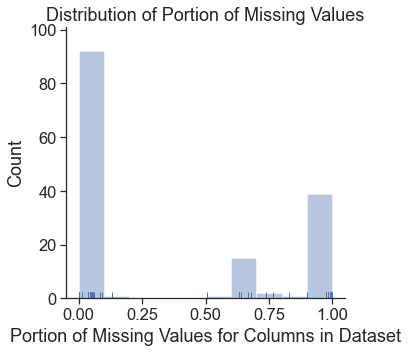

In [9]:
print('Number of Columns with under 15% missing values:', 
      missing_values_df[missing_values_df['Portion_Missing']<=0.15].shape[0])

#Plot the distribution of Portions of missing values for the columns
fig, ax = plt.subplots(figsize=(5,5))
sns.distplot(missing_values_df['Portion_Missing'], bins=10, kde=False, rug=True)
ax.set_title('Distribution of Portion of Missing Values')
ax.set_xlabel('Portion of Missing Values for Columns in Dataset')
ax.set_ylabel('Count')
sns.despine()

In [10]:
missing_grp = missing_values_df[(missing_values_df['Portion_Missing']>=0.6)&(missing_values_df['Portion_Missing']<=0.7)]
display(missing_grp)

missing_columns = missing_grp.index

earliest_date = []
for column in missing_columns:
    earliest_date.append(min(loan_df[~loan_df[column].isnull()]['issue_d'])) 

display(pd.DataFrame({'Column':missing_columns,
                      'Earliest issue_d for which column value is not null':earliest_date}))


,Missing_Count,Portion_Missing
il_util,43040,0.679604
mths_since_recent_revol_delinq,42276,0.667540
mths_since_rcnt_il,40611,0.641250
all_util,40031,0.632092
total_cu_tl,40030,0.632076
max_bal_bc,40030,0.632076
inq_last_12m,40030,0.632076
open_rv_12m,40030,0.632076
total_bal_il,40030,0.632076
open_il_24m,40030,0.632076


,Column,Earliest issue_d for which column value is not null
0,il_util,2015-12-01
1,mths_since_recent_revol_delinq,2012-03-01
2,mths_since_rcnt_il,2015-12-01
3,all_util,2015-12-01
4,total_cu_tl,2015-12-01
5,max_bal_bc,2015-12-01
6,inq_last_12m,2015-12-01
7,open_rv_12m,2015-12-01
8,total_bal_il,2015-12-01
9,open_il_24m,2015-12-01


In [11]:
exclude = ['id', 'member_id', 'url', 'next_pymnt_d', 'pymnt_plan', 'out_prncp',
           'out_prncp_inv', 'policy_code', 'open_acc_6m', 'open_act_il', 'open_il_12m',
           'open_il_24m', 'total_bal_il', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
           'inq_fi', 'total_cu_tl', 'inq_last_12m', 'il_util', 'all_util','mths_since_rcnt_il',
           'num_tl_120dpd_2m', 'num_tl_30dpd', 'deferral_term', 'hardship_amount',
           'hardship_dpd', 'hardship_end_date', 'hardship_flag', 'hardship_last_payment_amount',
           'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount',
           'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type',
           'orig_projected_additional_accrued_interest', 'payment_plan_start_date',
           'desc', 'title', 'emp_title', 'debt_settlement_flag', 'debt_settlement_flag_date',
           'settlement_amount', 'settlement_date', 'settlement_percentage', 'settlement_status',
           'settlement_term', 'recoveries', 'collection_recovery_fee', 'funded_amnt',
           'funded_amnt_inv', 'last_pymnt_amnt', 'out_prncp', 'out_prncp_inv',  'total_pymnt',
           'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp',
           'last_pymnt_d',  'last_credit_pull_d', 'disbursement_method', 'initial_list_status' ]

potential_features = np.setdiff1d(loan_df.columns.tolist(), exclude)

print(len(potential_features))
print(sorted(potential_features))

loan_df = loan_df[potential_features]

88
['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'annual_inc_joint', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'dti', 'dti_joint', 'earliest_cr_line', 'emp_length', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_fico_range_high', 'last_fico_range_low', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_90g_dpd_24m', 'num_tl_op_past_

In [12]:
def view_missingness_by_issue_d(df):
    missing_values_df = get_missing_values_table(df)
    earliest_date = []
    cols_with_missing_vals = missing_values_df[(missing_values_df.Portion_Missing<1) &
                                           (missing_values_df.Missing_Count >0)].index

    for column in cols_with_missing_vals:
        earliest_date.append(min(loan_df[~loan_df[column].isnull()]['issue_d'])) 

    df = pd.DataFrame({'Column':cols_with_missing_vals,
                      'Earliest issue_d for which column value is not null':earliest_date})
    
    return df.sort_values(by='Earliest issue_d for which column value is not null', ascending=False)

view_missingness_by_issue_d(loan_df).head(15)

,Column,Earliest issue_d for which column value is not null
0,sec_app_mths_since_last_major_derog,2017-03-01
1,sec_app_revol_util,2017-03-01
2,sec_app_inq_last_6mths,2017-03-01
3,sec_app_open_act_il,2017-03-01
4,sec_app_open_acc,2017-03-01
5,sec_app_num_rev_accts,2017-03-01
6,sec_app_earliest_cr_line,2017-03-01
7,sec_app_collections_12_mths_ex_med,2017-03-01
8,sec_app_fico_range_low,2017-03-01
9,sec_app_fico_range_high,2017-03-01


In [13]:
coborrower_cols =  ['annual_inc_joint', 'dti_joint', 'revol_bal_joint',
                    'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med',
                    'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc',
                    'sec_app_mths_since_last_major_derog', 'sec_app_num_rev_accts',
                    'sec_app_open_acc', 'sec_app_open_act_il', 'sec_app_revol_util',
                    'verification_status_joint']

potential_features = np.setdiff1d(loan_df.columns.tolist(), coborrower_cols)
loan_df = loan_df[potential_features]

In [14]:
display(view_missingness_by_issue_d(loan_df))

get_missing_values_table(loan_df).head(15)

,Column,Earliest issue_d for which column value is not null
0,sec_app_fico_range_high,2017-03-01
1,sec_app_fico_range_low,2017-03-01
16,num_actv_rev_tl,2012-08-01
29,num_actv_bc_tl,2012-08-01
28,num_tl_op_past_12m,2012-08-01
27,num_tl_90g_dpd_24m,2012-08-01
26,tot_hi_cred_lim,2012-08-01
25,tot_cur_bal,2012-08-01
24,tot_coll_amt,2012-08-01
22,num_rev_tl_bal_gt_0,2012-08-01


,Missing_Count,Portion_Missing
sec_app_fico_range_high,62609,0.988600
sec_app_fico_range_low,62609,0.988600
mths_since_last_record,52542,0.829641
mths_since_recent_bc_dlq,48435,0.764791
mths_since_last_major_derog,46643,0.736496
mths_since_recent_revol_delinq,42276,0.667540
mths_since_last_delinq,32047,0.506024
mths_since_recent_inq,8311,0.131231
mo_sin_old_il_acct,5212,0.082298
emp_length,3545,0.055976


In [15]:
print("Number of rows in dataset: {}".format (loan_df.shape[0]))

loan_df = loan_df[loan_df['issue_d']>=datetime(2012,8,1)]


print("Number of rows in dataset after removing loans issued prior to 2012-08-01: {}"\
      .format (loan_df.shape[0]))


Number of rows in dataset: 63331
Number of rows in dataset after removing loans issued prior to 2012-08-01: 60141


In [16]:
display(view_missingness_by_issue_d(loan_df))

get_missing_values_table(loan_df).head(15)

,Column,Earliest issue_d for which column value is not null
0,sec_app_fico_range_high,2017-03-01
1,sec_app_fico_range_low,2017-03-01
20,num_op_rev_tl,2012-08-01
21,num_il_tl,2012-08-01
22,num_actv_rev_tl,2012-08-01
23,num_accts_ever_120_pd,2012-08-01
24,num_actv_bc_tl,2012-08-01
25,num_bc_tl,2012-08-01
26,num_rev_tl_bal_gt_0,2012-08-01
27,total_rev_hi_lim,2012-08-01


,Missing_Count,Portion_Missing
sec_app_fico_range_high,59419,0.987995
sec_app_fico_range_low,59419,0.987995
mths_since_last_record,49524,0.823465
mths_since_recent_bc_dlq,45245,0.752315
mths_since_last_major_derog,43453,0.722519
mths_since_recent_revol_delinq,39284,0.653198
mths_since_last_delinq,29958,0.498129
mths_since_recent_inq,5833,0.096989
emp_length,3453,0.057415
mo_sin_old_il_acct,2022,0.033621


In [17]:
#emp_length
print('emp_length value counts: \n{}\n'.format(loan_df.emp_length.value_counts()))

emp_length value counts: 
10+ years    19998
2 years       5349
< 1 year      4835
3 years       4736
1 year        3883
5 years       3702
4 years       3592
8 years       2809
6 years       2797
7 years       2604
9 years       2383
Name: emp_length, dtype: int64



In [18]:
def process_emp_length(df):
    df_new = df.copy()
    #0-1 years inclues: null, None, < 1 year, 1 year
    df_new['emp_length'] = df_new['emp_length'].fillna('0-1 years')
    df_new['emp_length'] = np.where(df_new['emp_length'].isin([np.nan,None,'< 1 year','1 year']),
                                     '0-1 years',df_new['emp_length'])
    #2-4 years inclues: 2 years, 3 years, 4 years
    df_new['emp_length'] = np.where(df_new['emp_length'].isin(['2 years','3 years','4 years']),
                                     '2-4 years',df_new['emp_length'])
    
    #5-9 years inclues: 5 years, 6 years, 7 years, 8 years, 9 years
    df_new['emp_length'] = np.where(df_new['emp_length'].isin(['5 years','6 years','7 years','8 years','9 years']),
                                     '5-9 years',df_new['emp_length'])
    #10+ years includes 10+ years (no change)
    return df_new

def process_revol_util(df):
    df_new = df.copy()
    
    df_new['revol_util'] = df_new['revol_util'].fillna(-100)
    df_new['revol_util'] = df_new['revol_util'].apply(lambda x: float(str(x).split('%')[0])/100)
    df_new['revol_util'] = np.where(df_new['revol_util']==-1.0,np.nan,df_new['revol_util'])
    
    return df_new

def process_month_since_cols(df):
    df_new = df.copy()

    mo_since_cols = ['mo_sin_old_il_acct','mths_since_last_delinq','mths_since_last_major_derog',
                     'mths_since_last_record','mths_since_recent_bc_dlq','mths_since_recent_inq',
                     'mths_since_recent_revol_delinq','mo_sin_old_rev_tl_op','mths_since_recent_bc',
                     'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl']

    for col in mo_since_cols:
        df_new[col].fillna(df_new[col].max()+1, inplace=True)
    
    return df_new

def process_loan_grades(df):
    df_new = df.copy()
    
    # turn sub_grade into ordinal mapping
    sorted_subgrades = sorted(df.sub_grade.unique())
    subgrade_dict = dict(zip(sorted_subgrades, range(len(sorted_subgrades))))
    df_new['sub_grade'] = df_new['sub_grade'].map(subgrade_dict)
    
    # turn grade into ordinal mapping
    sorted_grades = sorted(df.grade.unique())
    grade_dict = dict(zip(sorted_grades, range(len(sorted_grades))))
    df_new['grade'] = df_new['grade'].map(grade_dict)
    return df_new
    
    
def process_loan_cols(df):
    df_processed = process_emp_length(df)
    df_processed = process_revol_util(df_processed)
    df_processed = process_month_since_cols(df_processed)
    df_processed = process_loan_grades(df_processed)
    
    #add credit_line_age
    df_processed['credit_line_age'] = df_processed['issue_d'] - pd.to_datetime(df_processed['earliest_cr_line'])
    df_processed = df_processed.drop(columns='earliest_cr_line')

    #process int_rate, zip_code, credit_line_age
    df_processed['int_rate'] = df_processed['int_rate'].apply(lambda x: float(str(x).split('%')[0])/100)
    df_processed['zip_code'] = df_processed['zip_code'].apply(lambda x: x[:3])
    df_processed['credit_line_age'] = df_processed['credit_line_age'].apply(lambda x: x.days)
    
    # generate new column for outcome variable ('fully_paid'); drop 'loan_status'
    df_processed['fully_paid'] = df_processed['loan_status'].map({'Fully Paid':1, 'Charged Off':0})
    df_processed = df_processed.drop(columns='loan_status')
    
    return df_processed

loan_df = process_loan_cols(loan_df)

In [19]:
missing_data = get_missing_values_table(loan_df)
display(missing_data[missing_data.Missing_Count!=0])
missing_cols = missing_data[missing_data.Missing_Count!=0].index

print("datatypes of the columns that still have missing values: ")
print(loan_df[missing_cols].dtypes.unique().tolist())

,Missing_Count,Portion_Missing
sec_app_fico_range_low,59419,0.987995
sec_app_fico_range_high,59419,0.987995
bc_util,653,0.010858
percent_bc_gt_75,624,0.010376
bc_open_to_buy,609,0.010126
pct_tl_nvr_dlq,238,0.003957
tot_coll_amt,233,0.003874
num_actv_bc_tl,233,0.003874
num_bc_tl,233,0.003874
num_il_tl,233,0.003874


datatypes of the columns that still have missing values: 
[dtype('float64')]


In [20]:
#Rerun Types
types_df = pd.DataFrame(loan_df.dtypes,columns=['Types'])
display(types_df[types_df['Types']!='float64'].sort_values(by='Types'))


object_vars=loan_df.select_dtypes(include='object').columns.tolist()
object_vars = np.setdiff1d(object_vars,['addr_state', 'zip_code'])
print(object_vars)

#Dummy encoding
loan_df = pd.get_dummies(loan_df,columns=object_vars,drop_first=True) 


,Types
grade,int64
issue_d,datetime64[ns]
sub_grade,int64
credit_line_age,int64
fully_paid,int64
addr_state,object
application_type,object
emp_length,object
home_ownership,object
purpose,object


['application_type' 'emp_length' 'home_ownership' 'purpose' 'term'
 'verification_status']


In [21]:
#columns where imputation is neededpd.
missing_cols = loan_df.columns[loan_df.isnull().any()].tolist()

#verify they're all continuous dtypes appropriate for linear regression imputation
loan_df[missing_cols].dtypes.unique() # all float64

array([dtype('float64')], dtype=object)

In [22]:
def impute_missing_continuous(df, missing_columns, cols_to_exclude):
    clean_df = df.copy()
    
    for column in missing_columns:
        types_df = pd.DataFrame(df.dtypes,columns=['Types'])
        # Remove response variable
        impute_train = clean_df[~clean_df[column].isnull()].drop(cols_to_exclude,1).sample(frac=0.1,random_state=12)

        #Split target
        X_impute_train = impute_train.drop(column,1)
        Y_impute_train = impute_train[column]

        #Mean Imputation for current nulls for columns that did not get imputed yet
        X_impute_train = X_impute_train.fillna(X_impute_train.mean())

        # Train LinearRegression
        impute_ols = LinearRegression(fit_intercept=True)
        impute_ols.fit(X_impute_train,Y_impute_train)

        # Generate new temp column with model predictions
        # Only replace rows where the value is null with the K-NN predicted value 
        predictions = clean_df.drop(cols_to_exclude + [column],1)

        #Mean Imputation for current nulls for columns that did not get imputed yet
        predictions = predictions.fillna(predictions.mean())
        clean_df['temp'] = impute_ols.predict(predictions)

        clean_df[column] = np.where(clean_df[column].isnull(),clean_df['temp'],clean_df[column])
        clean_df = clean_df.drop('temp',1)
    
    return clean_df

clean_df = impute_missing_continuous(loan_df, missing_columns=missing_cols, cols_to_exclude=['fully_paid','issue_d', 'zip_code', 'addr_state'])

In [23]:
clean_df.isnull().values.any()

False

In [24]:
print("float64 columns: ")
print(clean_df.dtypes[clean_df.dtypes=='float64'].index.tolist())

print("\nnon-float64 columns: ")
print(clean_df.dtypes[clean_df.dtypes!='float64'])

print("\n\nVisualizing unique values for non-float64 variables (except for zip_code and issue_d)")
for col in clean_df.dtypes[clean_df.dtypes!='float64'].index.tolist():
    if not col in['issue_d', 'zip_code']:
        print("\n", col)
        print(clean_df[col].unique())


float64 columns: 
['acc_now_delinq', 'acc_open_past_24mths', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'dti', 'fico_range_high', 'fico_range_low', 'inq_last_6mths', 'installment', 'int_rate', 'last_fico_range_high', 'last_fico_range_low', 'loan_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'revol_util', 'sec_app_fico_range_h

In [25]:
clean_df.to_pickle('clean_df_5pct_subset.pkl')

In [26]:
loan_df = pd.read_pickle('loan_df0.pkl')

exclude = ['id', 'member_id', 'url', 'next_pymnt_d', 'pymnt_plan', 'out_prncp',
           'out_prncp_inv', 'policy_code', 'open_acc_6m', 'open_act_il', 'open_il_12m',
           'open_il_24m', 'total_bal_il', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
           'inq_fi', 'total_cu_tl', 'inq_last_12m', 'il_util', 'all_util','mths_since_rcnt_il',
           'num_tl_120dpd_2m', 'num_tl_30dpd', 'deferral_term', 'hardship_amount',
           'hardship_dpd', 'hardship_end_date', 'hardship_flag', 'hardship_last_payment_amount',
           'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount',
           'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type',
           'orig_projected_additional_accrued_interest', 'payment_plan_start_date',
           'desc', 'title', 'emp_title', 'debt_settlement_flag', 'debt_settlement_flag_date',
           'settlement_amount', 'settlement_date', 'settlement_percentage', 'settlement_status',
           'settlement_term', 'recoveries', 'collection_recovery_fee', 'funded_amnt',
           'funded_amnt_inv', 'last_pymnt_amnt', 'out_prncp', 'out_prncp_inv',  'total_pymnt',
           'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp',
           'last_pymnt_d',  'last_credit_pull_d', 'disbursement_method', 'initial_list_status',
           'annual_inc_joint', 'dti_joint', 'revol_bal_joint','sec_app_chargeoff_within_12_mths',
           'sec_app_collections_12_mths_ex_med','sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
           'sec_app_mort_acc','sec_app_mths_since_last_major_derog', 'sec_app_num_rev_accts',
           'sec_app_open_acc', 'sec_app_open_act_il', 'sec_app_revol_util',
           'verification_status_joint']

potential_features = np.setdiff1d(loan_df.columns.tolist(), exclude)
loan_df = loan_df[potential_features]

loan_df = loan_df[loan_df['issue_d']>=datetime(2012,8,1)]

loan_df = process_loan_cols(loan_df)

object_vars = loan_df.select_dtypes(include='object').columns.tolist()
vars_for_dummies = np.setdiff1d(object_vars,['addr_state', 'zip_code'])

tmp_df = loan_df[vars_for_dummies]
loan_df = pd.get_dummies(loan_df,columns=vars_for_dummies,drop_first=True) 

missing_cols = loan_df.columns[loan_df.isnull().any()].tolist()

clean_df = impute_missing_continuous(loan_df, missing_columns=missing_cols,
                                     cols_to_exclude=['fully_paid','issue_d', 'zip_code', 'addr_state'])

for col in vars_for_dummies:
    clean_df[col] = tmp_df[col]
    
print(sorted(clean_df.columns.tolist()))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'application_type_Joint App', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'credit_line_age', 'delinq_2yrs', 'delinq_amnt', 'dti', 'emp_length', 'emp_length_10+ years', 'emp_length_2-4 years', 'emp_length_5-9 years', 'fico_range_high', 'fico_range_low', 'fully_paid', 'grade', 'home_ownership', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_fico_range_high', 'last_fico_range_low', 'loan_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'n

In [31]:
print(clean_df.shape)
#print(vars_for_dummies)

(1203682, 99)


In [32]:
clean_df.to_pickle('clean_df_for_eda.pkl')

In [29]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

from IPython.display import clear_output
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('ticks')

from os import listdir
from os.path import isfile, join
import os
#os.getcwd()
os.chdir('/Users/Grant/Documents/Model Risk Mgmt/')
import warnings
warnings.filterwarnings('ignore')


Need to cut down to 200k rows while keeping the target distribution

**Your code below**

*   Reduce the overall data set to 200K rows or less
*   Split your data for training / testing
*   Build at least two models with `loan_status` as the target
*   Report on the model's performance
*   Report on the model's drivers (feature importance / effects)

Plant 2 flaws in this notebook.  Do not "give away" the answers here.  This notebook should appear, at first glance, to create a viable model.

Make a note of your flaws and be prepared to talk about how the code / results look when they are "fixed".  You will need to talk about those in the final presentation.